<a href="https://colab.research.google.com/github/airenare/pneumonia_xray/blob/main/Pneumonia_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray CNN to Detect Pneumonia

## Data Processing and Modeling

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

import os

from google.colab import drive


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Importing the Datasets from Kaggle

In [3]:
# !pip install kaggle

In [24]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Kaggle json path
kaggle_path = '/content/drive/MyDrive/kaggle.json'

In [6]:
!mkdir ~/.kaggle
!cp {kaggle_path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls

drive  sample_data


In [7]:
kaggle_1 = 'paultimothymooney/chest-xray-pneumonia'
kaggle_2 = 'salonimate/covid-pneumonia-nomal-xray'

In [33]:
# # make sure kaggle uses kaggle.json file
# !kaggle config set -n path -v /content/images

# # Download both datasets in the working directory
# !kaggle datasets download -d {kaggle_1}
# !kaggle datasets download -d {kaggle_2}

- path is now set to: /content/images
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:59<00:00, 21.9MB/s]
100% 2.29G/2.29G [01:59<00:00, 20.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/salonimate/covid-pneumonia-nomal-xray
License(s): unknown
100% 1.91G/1.91G [01:35<00:00, 23.8MB/s]
100% 1.91G/1.91G [01:35<00:00, 21.5MB/s]


In [34]:
drive_images_path = 'drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/images'

In [58]:
# Function to get datasets from Kaggle
def get_kaggle_dataset(dataset_name, download_folder,
                       save_to_drive=False, drive_path=None,
                       delete_zip=True, delete_MACOSX=True):
  """
  Downloads a dataset from Kaggle or Google Drive.

  Args:
    dataset_name: The name of the dataset to download.
    download_folder: The folder where the dataset will be downloaded (no trailing /)
    save_to_drive: Whether to save the dataset to Google Drive.
    drive_path: The path to the Google Drive folder where the dataset will be saved.
  """
  # Check if the dataset is already downloaded
  if os.path.exists(f'{download_folder}/{dataset_name}.zip'):
    print(f'Dataset {dataset_name} already downloaded.')
    return

  # Set download folder
  !kaggle config set -n path -v {download_folder}

  # Download the dataset
  !kaggle datasets download -d {dataset_name}

  # Unzip the dataset
  !unzip -q {download_folder}/datasets/{dataset_name}/{dataset_name.split("/")[-1]}.zip -d {download_folder}

  # Save to drive
  if save_to_drive:
    !cp /content/images/datasets/{dataset_name}/{dataset_name.split("/")[-1]}.zip {drive_path}
    print(f'Dataset {dataset_name} saved to Google Drive.')

  # Delete the zip archive
  if delete_zip:
    !rm {download_folder}/{dataset_path.split("/")[-1]}

  # Remove the __MACOSX folder
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX')\
   and remove_MACOSX:
    !rm -r {download_folder}/__MACOSX
    print('__MACOSX folder removed.')

  print(f'Dataset {dataset_name} downloaded and saved.')

In [74]:
# Function to get datasets from Google Drive
def get_drive_dataset(dataset_path, download_folder,
                      delete_zip=True, remove_MACOSX=True):
  """
  Downloads a dataset from Google Drive.

  Args:
    dataset_path: The path to the dataset in Google Drive.
    download_folder: The folder where the dataset will be downloaded (no trailing /)
  """

  # Create download folder if does not exist
  if not os.path.exists(download_folder):
    !mkdir {download_folder}
    print(f'Download folder {download_folder} created.')
  else:
    print(f'Download folder {download_folder} already exists.')

  # Check if the dataset is already downloaded
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-1]}'):
    print(f'Dataset {dataset_path.split("/")[-1]} already downloaded.')
    # Delete zip if still there
    if delete_zip:
      !rm {download_folder}/{dataset_path.split("/")[-1]}
      print(f'Zip archive {dataset_path.split("/")[-1]} removed.')
    # Remove the __MACOSX folder
    if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX') and remove_MACOSX:
      !rm -r {download_folder}/__MACOSX
      print('__MACOSX folder removed.')
    return

  # Remove the __MACOSX folder
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX') and remove_MACOSX:
    !rm -r {download_folder}/__MACOSX
    print('__MACOSX folder removed.')

  # Download the dataset and skip if exists
  !cp {dataset_path} {download_folder} --no-clobber
  print(f'Dataset {dataset_path.split("/")[-1]} downloaded.')

  # Unzip the dataset
  !unzip -q {download_folder}/{dataset_path.split("/")[-1]} -d {download_folder}
  print(f'Dataset {dataset_path.split("/")[-1]} unzipped.')

  # Delete the zip archive
  if delete_zip:
    !rm {download_folder}/{dataset_path.split("/")[-1]}
    print(f'Zip archive {dataset_path.split("/")[-1]} removed.')

  # Remove the __MACOSX folder
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX') and remove_MACOSX:
    !rm -r {download_folder}/__MACOSX
    print('__MACOSX folder removed.')

  print(f'Dataset {dataset_path.split("/")[-1]} downloaded and saved.')

In [49]:
!ls {drive_images_path}

chest-xray-pneumonia.zip  covid-pneumonia-nomal-xray.zip


In [75]:
get_drive_dataset(f'{drive_images_path}/chest-xray-pneumonia.zip', '/content/images')

Download folder /content/images_2 already exists.
Dataset chest-xray-pneumonia.zip downloaded.
Dataset chest-xray-pneumonia.zip unzipped.
Zip archive chest-xray-pneumonia.zip removed.
Dataset chest-xray-pneumonia.zip downloaded and saved.


In [56]:
get_drive_dataset(f'{drive_images_path}/covid-pneumonia-nomal-xray.zip', '/content/images')

Dataset covid-pneumonia-nomal-xray.zip downloaded and saved.


In [76]:
!rm -r /content/images/chest_xray/__MACOSX
!rm -r /content/images/chest_xray/chest_xray

### Combine the datasets

In [81]:
# Define the image size and batch size
img_height = 128
img_width = 128
batch_size = 32

In [82]:
ds_1_path = '/content/images/chest_xray'
ds_2_path = '/content/images/New-CNP-Dataset'

In [83]:
train_dir_1 = f"{ds_1_path}/train"
val_dir_1 = f"{ds_1_path}/val"
test_dir_1 = f"{ds_1_path}/test"

train_dir_2 = f"{ds_2_path}/train"
val_dir_2 = f"{ds_2_path}/validation"
test_dir_2 = f"{ds_2_path}/testing"

In [118]:
# First DS
print("First directory")
train_ds_1 = image_dataset_from_directory(
    train_dir_1,
    color_mode='rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds_1 = image_dataset_from_directory(
    val_dir_1,
    color_mode='rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds_1 = image_dataset_from_directory(
    test_dir_1,
    color_mode='rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size)

# Second DS
print("Second directory")
train_ds_2 = image_dataset_from_directory(
    train_dir_2,
    color_mode='rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds_2 = image_dataset_from_directory(
    val_dir_2,
    color_mode='rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds_2 = image_dataset_from_directory(
    test_dir_2,
    color_mode='rgb',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    )

First directory
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Second directory
Found 4488 files belonging to 3 classes.
Found 1033 files belonging to 3 classes.
Found 1381 files belonging to 3 classes.


In [119]:
# Get the class names
class_names_1 = {i: train_ds_1.class_names[i] for i in range(len(train_ds_1.class_names))}
# Get the class names
class_names_2 = {i: train_ds_2.class_names[i] for i in range(len(train_ds_2.class_names))}

class_names_1, class_names_2

({0: 'NORMAL', 1: 'PNEUMONIA'}, {0: 'covid', 1: 'normal', 2: 'pneumonia'})

In [120]:
# Function to preview images from dataset
def preview_images(dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
      for i in range(9):
          plt.subplot(3,3, i + 1)
          plt.imshow(np.squeeze(images[i].numpy().astype('uint8')), cmap='gray')
          plt.title(dataset.class_names[labels[i]])
          plt.axis("off")

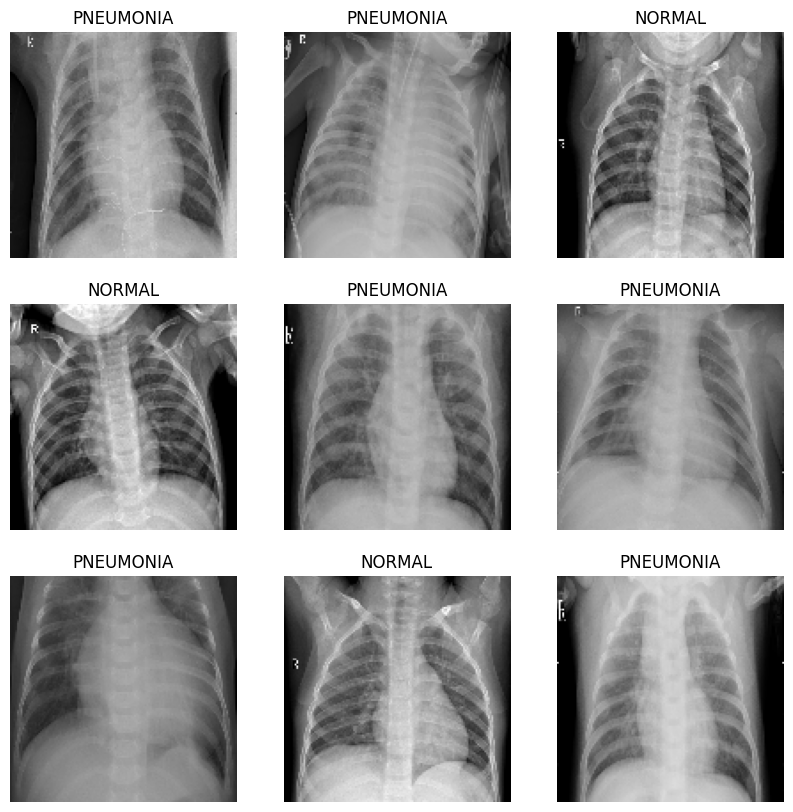

In [121]:
preview_images(train_ds_1)

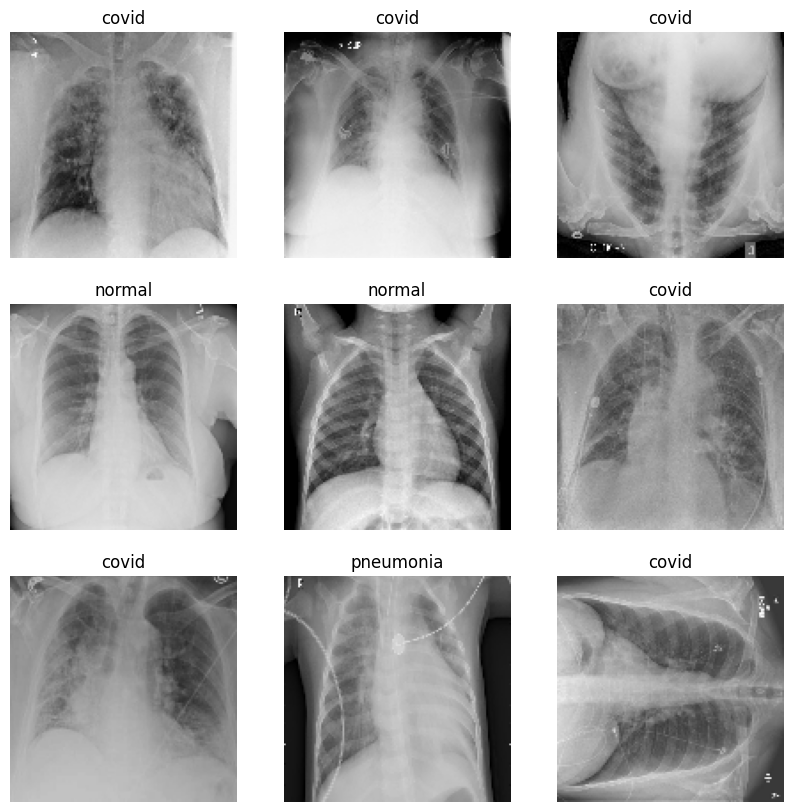

In [122]:
preview_images(train_ds_2)

In [123]:
# GEt shape of images in train_ds_1
for image_batch, labels_batch in train_ds_1.take(1):
  print(image_batch.shape)

for image_batch, labels_batch in train_ds_2.take(1):
  print(image_batch.shape)

(32, 128, 128, 3)
(32, 128, 128, 3)


In [124]:
# Function to show the number of images for each category within a dataset
def show_num_images(dataset, directory):
  classes = dataset.class_names
  num_images_per_class = []
  for cls in classes:
    num_images_per_class.append(len(os.listdir(f"{directory}/{cls}")))
  df = pd.DataFrame({'Class': classes, 'Number of Images': num_images_per_class})
  print(df)
  sns.barplot(x='Class', y='Number of Images', data=df)
  plt.show()
  return df

       Class  Number of Images
0     NORMAL              1341
1  PNEUMONIA              3875


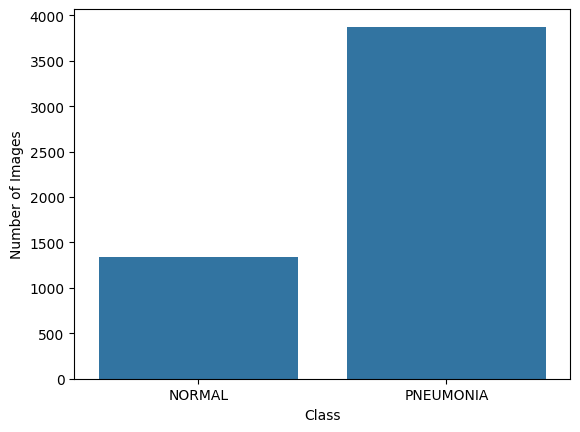

,Class,Number of Images
0,NORMAL,1341
1,PNEUMONIA,3875


In [125]:
show_num_images(train_ds_1, train_dir_1)

       Class  Number of Images
0      covid              1505
1     normal              1505
2  pneumonia              1505


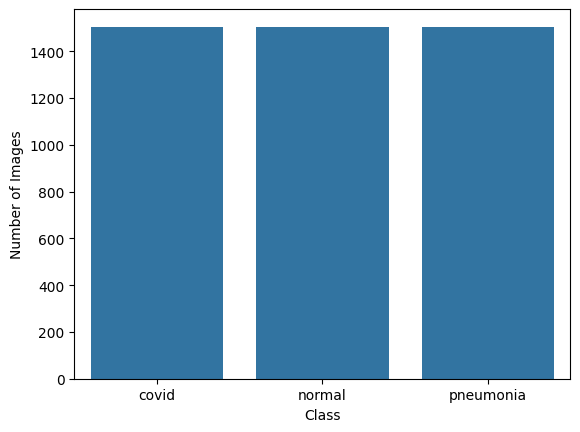

,Class,Number of Images
0,covid,1505
1,normal,1505
2,pneumonia,1505


In [126]:
show_num_images(train_ds_2, train_dir_2)

In [127]:
# Create a new directory 'combined' in /content/images folder and copy the contents of /content/images/chest_xray
!mkdir /content/images/combined
!cp -r /content/images/chest_xray/test /content/images/combined
!cp -r /content/images/chest_xray/train /content/images/combined
!cp -r /content/images/chest_xray/val /content/images/combined

In [128]:
# Copy the contents of /content/images/New-CNP-Dataset/train/normal folder into the /content/images/combined/train/NORMAL
!cp -r /content/images/New-CNP-Dataset/train/normal/* /content/images/combined/train/NORMAL

In [129]:
ds_path = '/content/images/combined'

In [130]:
train_dir = f"{ds_path}/train"
val_dir = f"{ds_path}/val"
test_dir = f"{ds_path}/test"

In [131]:
# Create the new datasets
train_ds = image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds = image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 6503 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


       Class  Number of Images
0     NORMAL              2628
1  PNEUMONIA              3875


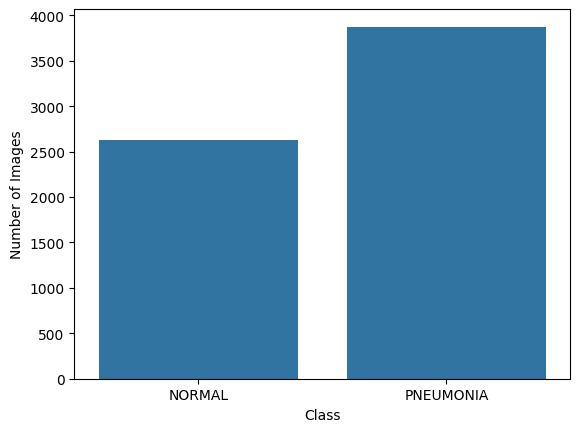

,Class,Number of Images
0,NORMAL,2628
1,PNEUMONIA,3875


In [132]:
class_df = show_num_images(train_ds, train_dir)
class_df.head()

This looks much better than before. Let's get the class weights now.

In [133]:
# Add the class_weight column to the class_df
class_df['class_weight'] = class_df['Number of Images'] / class_df['Number of Images'].sum()
class_df

,Class,Number of Images,class_weight
0,NORMAL,2628,0.404121
1,PNEUMONIA,3875,0.595879


### Modeling

In [134]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [135]:
model = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [136]:
class_weights = {0: class_df['class_weight'][0], 1: class_df['class_weight'][1]}
class_weights

{0: 0.4041211748423804, 1: 0.5958788251576196}

In [137]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [138]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/20
204/204 [==============================] - 17s 42ms/step - loss: 0.5927 - accuracy: 0.7178 - val_loss: 0.6110 - val_accuracy: 0.6875
Epoch 2/20
204/204 [==============================] - 2s 11ms/step - loss: 0.1863 - accuracy: 0.8272 - val_loss: 0.7546 - val_accuracy: 0.6250
Epoch 3/20
204/204 [==============================] - 2s 11ms/step - loss: 0.1678 - accuracy: 0.8475 - val_loss: 0.6383 - val_accuracy: 0.8125
Epoch 4/20
204/204 [==============================] - 2s 11ms/step - loss: 0.1556 - accuracy: 0.8634 - val_loss: 0.6727 - val_accuracy: 0.6875
Epoch 5/20
204/204 [==============================] - 2s 11ms/step - loss: 0.1505 - accuracy: 0.8647 - val_loss: 0.6389 - val_accuracy: 0.7500
Epoch 6/20
204/204 [==============================] - 2s 11ms/step - loss: 0.1469 - accuracy: 0.8733 - val_loss: 1.0040 - val_accuracy: 0.6250
Epoch 7/20
204/204 [==============================] - 2s 11ms/step - loss: 0.1485 - accuracy: 0.8773 - val_loss: 1.0332 - val_accuracy: 0.625

In [139]:
# Function to plot training history
def plot_history(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

In [140]:
# Function to show the confusion matrix
def show_cm(model):
    # Define class names
    class_names = ['NORMAL', 'PNEUMONIA']

    # List to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset and make predictions
    for images, labels in test_ds:
        # Make predictions
        predictions = model.predict(images)
        # Get predicted labels
        predicted_labels.extend(np.argmax(predictions, axis=1))
        # Get true labels
        true_labels.extend(labels.numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

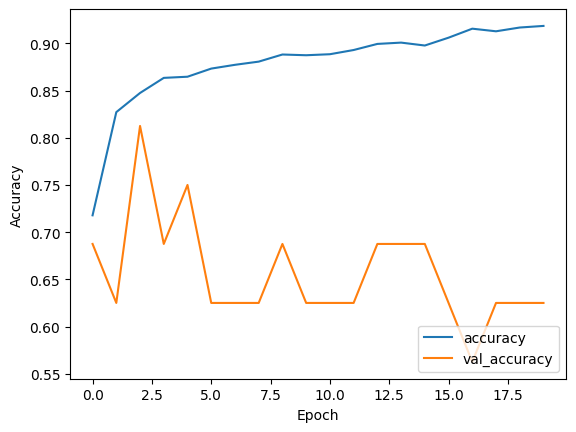

In [141]:
plot_history(history)

1/1 [==============================] - 0s 82ms/step


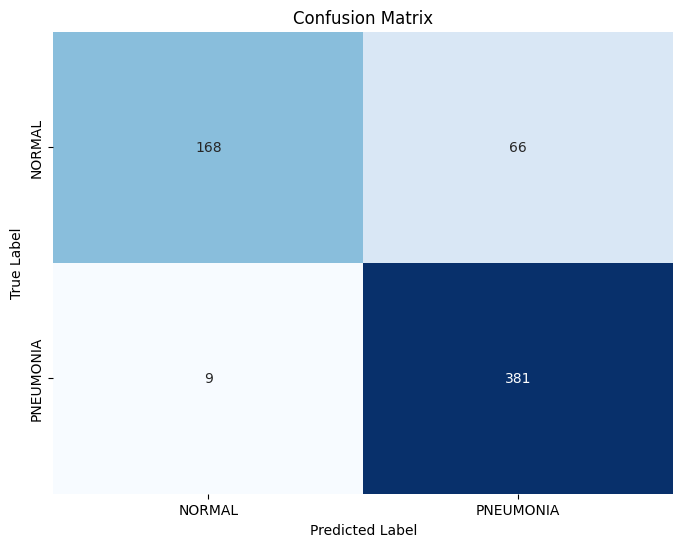

In [142]:
show_cm(model)

In [143]:
# Accuracy of model
model.evaluate(test_ds)

20/20 [==============================] - 0s 5ms/step - loss: 0.3809 - accuracy: 0.8798


[0.3809341788291931, 0.879807710647583]

In [145]:
# Save model as keras, json and weights
!mkdir model_1
model.save('model_1/model.keras')
model_json = model.to_json()
with open("model_1/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_1/model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [146]:
# Zip the model_1 folder and upload it to drive
!zip -r model_1.zip model_1

!cp model_1.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_1.zip

  adding: model_1/ (stored 0%)
  adding: model_1/model_weights.h5 (deflated 8%)
  adding: model_1/model.json (deflated 88%)
  adding: model_1/model.keras (deflated 31%)


### Train new model on just the second dataset's normal and pneumonia classes

In [155]:
!rm -r /content/images/test_2

In [156]:
!mkdir /content/images/ds_2_no_covid
!cp -r /content/images/New-CNP-Dataset/* /content/images/ds_2_no_covid
!rm -r /content/images/ds_2_no_covid/testing/covid
!rm -r /content/images/ds_2_no_covid/train/covid
!rm -r /content/images/ds_2_no_covid/validation/covid
!ls /content/images/ds_2_no_covid/testing
!ls /content/images/ds_2_no_covid/train
!ls /content/images/ds_2_no_covid/validation

normal	pneumonia
normal	pneumonia
normal	pneumonia


In [158]:
!mkdir /content/images/ds_2_no_covid/testing/NORMAL
!mkdir /content/images/ds_2_no_covid/testing/PNEUMONIA
!mkdir /content/images/ds_2_no_covid/train/NORMAL
!mkdir /content/images/ds_2_no_covid/train/PNEUMONIA
!mkdir /content/images/ds_2_no_covid/validation/NORMAL
!mkdir /content/images/ds_2_no_covid/validation/PNEUMONIA

!mv /content/images/ds_2_no_covid/testing/normal/* /content/images/ds_2_no_covid/testing/NORMAL
!mv /content/images/ds_2_no_covid/testing/pneumonia/* /content/images/ds_2_no_covid/testing/PNEUMONIA

!mv /content/images/ds_2_no_covid/train/normal/* /content/images/ds_2_no_covid/train/NORMAL
!mv /content/images/ds_2_no_covid/train/pneumonia/* /content/images/ds_2_no_covid/train/PNEUMONIA

!mv /content/images/ds_2_no_covid/validation/normal/* /content/images/ds_2_no_covid/validation/NORMAL
!mv /content/images/ds_2_no_covid/validation/pneumonia/* /content/images/ds_2_no_covid/validation/PNEUMONIA

!ls /content/images/ds_2_no_covid/testing
!ls /content/images/ds_2_no_covid/train
!ls /content/images/ds_2_no_covid/validation

rm: cannot remove '/content/images/ds_2_no_covid/testing/normal': Is a directory
rm: cannot remove '/content/images/ds_2_no_covid/testing/pneumonia': Is a directory
rm: cannot remove '/content/images/ds_2_no_covid/validation/normal': Is a directory
rm: cannot remove '/content/images/ds_2_no_covid/validation/pneumonia': Is a directory
rm: cannot remove '/content/images/ds_2_no_covid/train/normal': Is a directory
rm: cannot remove '/content/images/ds_2_no_covid/train/pneumonia': Is a directory
normal	NORMAL	pneumonia  PNEUMONIA
normal	NORMAL	pneumonia  PNEUMONIA
normal	NORMAL	pneumonia  PNEUMONIA


In [159]:
!rm -r /content/images/ds_2_no_covid/testing/normal
!rm -r /content/images/ds_2_no_covid/testing/pneumonia
!rm -r /content/images/ds_2_no_covid/validation/normal
!rm -r /content/images/ds_2_no_covid/validation/pneumonia
!rm -r /content/images/ds_2_no_covid/train/normal
!rm -r /content/images/ds_2_no_covid/train/pneumonia

In [161]:
ds_path = '/content/images/ds_2_no_covid'

In [164]:
train_dir = f"{ds_path}/train"
val_dir = f"{ds_path}/validation"
test_dir = f"{ds_path}/testing"

In [171]:
# Create the new datasets
train_ds = image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds = image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3010 files belonging to 2 classes.
Found 692 files belonging to 2 classes.
Found 924 files belonging to 2 classes.


       Class  Number of Images
0     NORMAL              1505
1  PNEUMONIA              1505


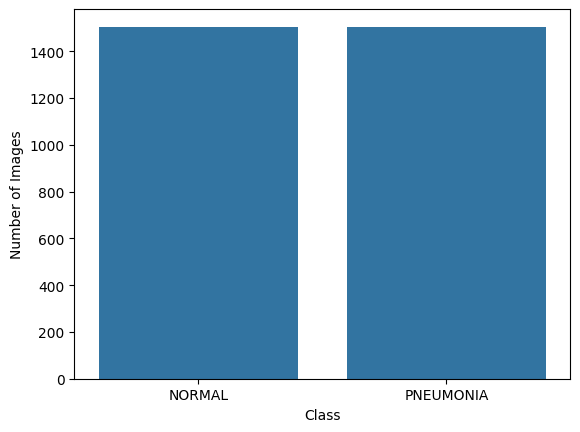

,Class,Number of Images,class_weight
0,NORMAL,1505,0.5
1,PNEUMONIA,1505,0.5


In [172]:
class_df = show_num_images(train_ds, train_dir)
# Add the class_weight column to the class_df
class_df['class_weight'] = class_df['Number of Images'] / class_df['Number of Images'].sum()
class_df.head()

In [173]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [174]:
model = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [175]:
class_weights = {0: class_df['class_weight'][0], 1: class_df['class_weight'][1]}
class_weights

{0: 0.5, 1: 0.5}

In [176]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [177]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/20
95/95 [==============================] - 8s 53ms/step - loss: 1.7741 - accuracy: 0.6654 - val_loss: 0.5236 - val_accuracy: 0.7312
Epoch 2/20
95/95 [==============================] - 1s 13ms/step - loss: 0.2203 - accuracy: 0.8176 - val_loss: 0.3970 - val_accuracy: 0.8526
Epoch 3/20
95/95 [==============================] - 1s 13ms/step - loss: 0.2084 - accuracy: 0.8399 - val_loss: 0.3592 - val_accuracy: 0.8887
Epoch 4/20
95/95 [==============================] - 1s 13ms/step - loss: 0.2056 - accuracy: 0.8289 - val_loss: 0.3581 - val_accuracy: 0.8757
Epoch 5/20
95/95 [==============================] - 1s 12ms/step - loss: 0.2015 - accuracy: 0.8452 - val_loss: 0.3634 - val_accuracy: 0.8858
Epoch 6/20
95/95 [==============================] - 1s 12ms/step - loss: 0.1965 - accuracy: 0.8472 - val_loss: 0.3668 - val_accuracy: 0.8526
Epoch 7/20
95/95 [==============================] - 1s 12ms/step - loss: 0.1926 - accuracy: 0.8628 - val_loss: 0.3285 - val_accuracy: 0.8829
Epoch 8/20
95

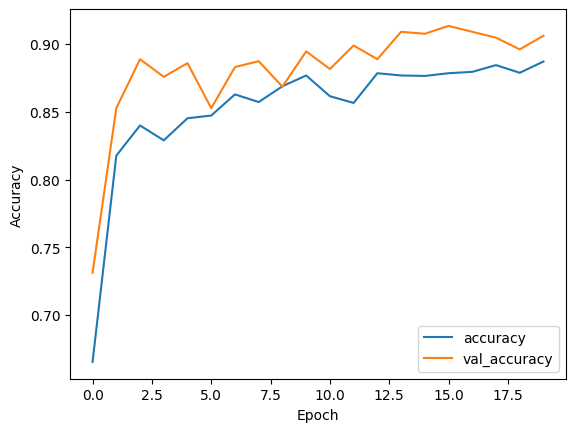

In [178]:
plot_history(history)


1/1 [==============================] - 0s 228ms/step


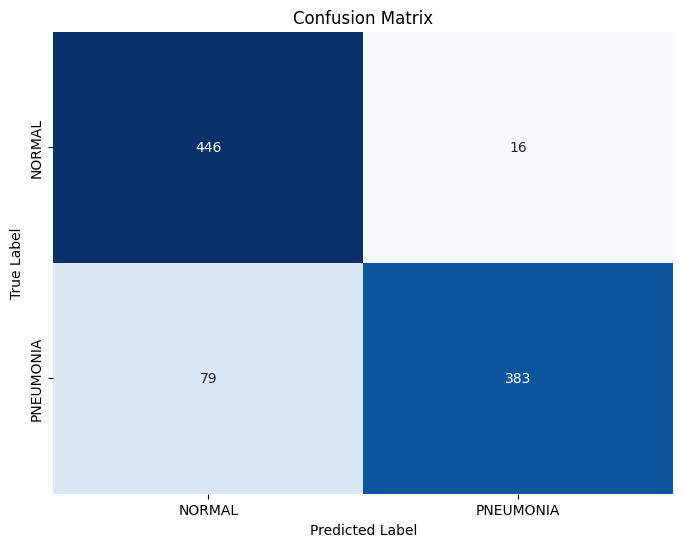

In [179]:
show_cm(model)


In [180]:
# Accuracy of model
model.evaluate(test_ds)

29/29 [==============================] - 0s 5ms/step - loss: 0.3164 - accuracy: 0.8972


[0.3163720667362213, 0.8971861600875854]

In [181]:
# Save model as keras, json and weights
!mkdir model_2
model.save('model_2/model.keras')
model_json = model.to_json()
with open("model_2/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_2/model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [182]:
# Zip the model_2 folder and upload it to drive
!zip -r model_2.zip model_2

!cp model_2.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_2.zip
print("Saved to drive")

  adding: model_2/ (stored 0%)
  adding: model_2/model_weights.h5 (deflated 8%)
  adding: model_2/model.json (deflated 88%)
  adding: model_2/model.keras (deflated 33%)
Saved to drive


# Finetune the model with the dataset of the first model

In [183]:
ds_path = '/content/images/combined'


In [184]:
train_dir = f"{ds_path}/train"
val_dir = f"{ds_path}/val"
test_dir = f"{ds_path}/test"

In [185]:
# Create the new datasets
train_ds = image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds = image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 6503 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


       Class  Number of Images
0     NORMAL              2628
1  PNEUMONIA              3875


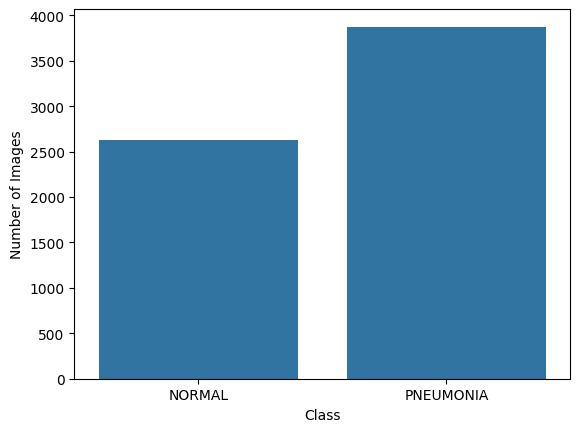

,Class,Number of Images
0,NORMAL,2628
1,PNEUMONIA,3875


In [186]:
class_df = show_num_images(train_ds, train_dir)
class_df.head()

In [187]:
# Add the class_weight column to the class_df
class_df['class_weight'] = class_df['Number of Images'] / class_df['Number of Images'].sum()
class_df

,Class,Number of Images,class_weight
0,NORMAL,2628,0.404121
1,PNEUMONIA,3875,0.595879


In [188]:
class_weights = {0: class_df['class_weight'][0], 1: class_df['class_weight'][1]}
class_weights

{0: 0.4041211748423804, 1: 0.5958788251576196}

In [189]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1603 - accuracy: 0.8618 - val_loss: 0.8208 - val_accuracy: 0.6875
Epoch 2/10
204/204 [==============================] - 9s 42ms/step - loss: 0.1513 - accuracy: 0.8678 - val_loss: 0.6720 - val_accuracy: 0.6250
Epoch 3/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1511 - accuracy: 0.8705 - val_loss: 0.7315 - val_accuracy: 0.7500
Epoch 4/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1439 - accuracy: 0.8777 - val_loss: 0.7937 - val_accuracy: 0.6875
Epoch 5/10
204/204 [==============================] - 9s 42ms/step - loss: 0.1450 - accuracy: 0.8787 - val_loss: 0.7496 - val_accuracy: 0.5625
Epoch 6/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1409 - accuracy: 0.8841 - val_loss: 0.8797 - val_accuracy: 0.6875
Epoch 7/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1319 - accuracy: 0.8884 - val_loss: 0.7299 - val_accuracy: 0.7500

1/1 [==============================] - 0s 24ms/step


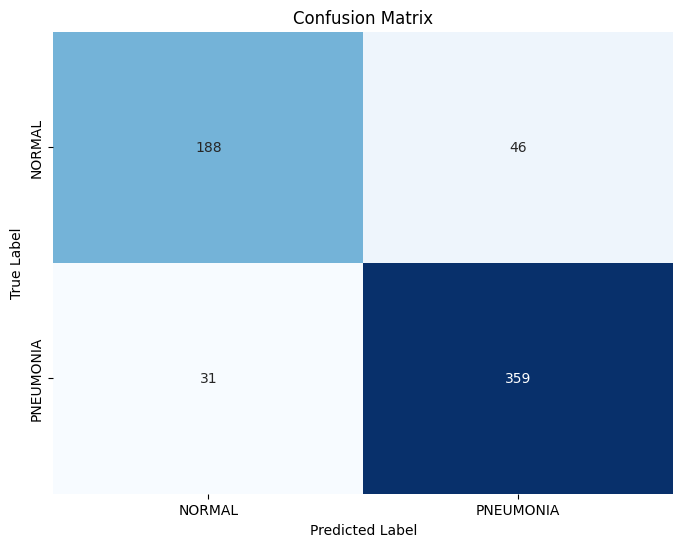

In [190]:
show_cm(model)

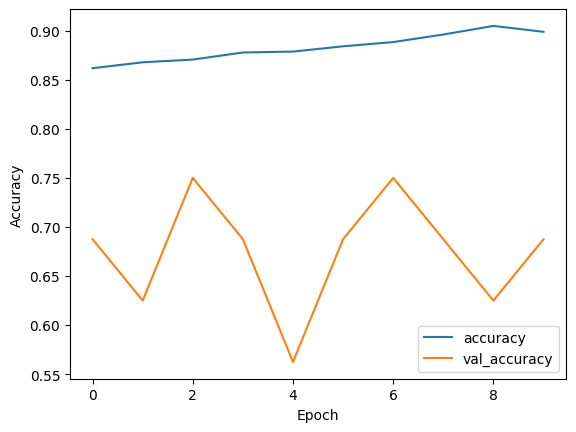

In [192]:
plot_history(history)

In [193]:
# Accuracy of model
model.evaluate(test_ds)

20/20 [==============================] - 1s 20ms/step - loss: 0.3427 - accuracy: 0.8766


[0.3426891565322876, 0.8766025900840759]

In [194]:
# Save model as keras, json and weights
!mkdir model_3
model.save('model_3/model.keras')
model_json = model.to_json()
with open("model_3/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_3/model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [195]:
# Zip the model_3 folder and upload it to drive
!zip -r model_3.zip model_3

!cp model_3.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_3.zip
print("Saved to drive")

  adding: model_3/ (stored 0%)
  adding: model_3/model_weights.h5 (deflated 8%)
  adding: model_3/model.json (deflated 88%)
  adding: model_3/model.keras (deflated 31%)
Saved to drive


# More finetuning epochs on the same dataset

In [196]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1194 - accuracy: 0.9077 - val_loss: 1.2228 - val_accuracy: 0.6875
Epoch 2/10
204/204 [==============================] - 9s 44ms/step - loss: 0.1169 - accuracy: 0.9065 - val_loss: 0.7437 - val_accuracy: 0.6875
Epoch 3/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1154 - accuracy: 0.9102 - val_loss: 0.8421 - val_accuracy: 0.6875
Epoch 4/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1199 - accuracy: 0.9088 - val_loss: 0.7378 - val_accuracy: 0.6875
Epoch 5/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1075 - accuracy: 0.9127 - val_loss: 0.6892 - val_accuracy: 0.8125
Epoch 6/10
204/204 [==============================] - 9s 42ms/step - loss: 0.1117 - accuracy: 0.9137 - val_loss: 0.9451 - val_accuracy: 0.6875
Epoch 7/10
204/204 [==============================] - 9s 43ms/step - loss: 0.1063 - accuracy: 0.9145 - val_loss: 0.8640 - val_accuracy: 0.5625

1/1 [==============================] - 0s 23ms/step


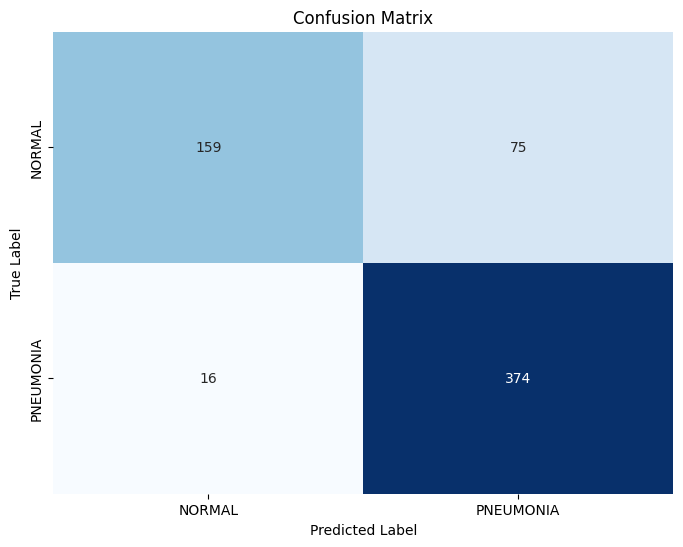

In [197]:
show_cm(model)

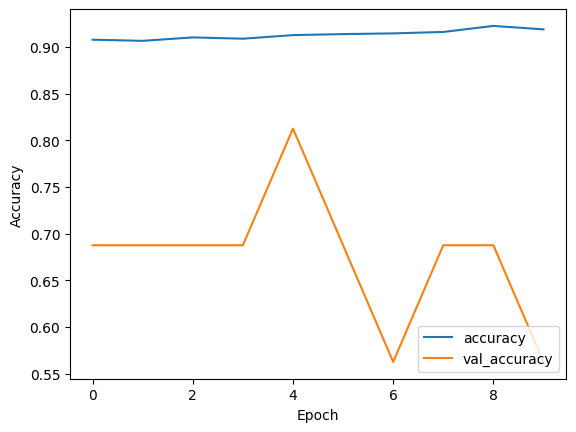

In [198]:
plot_history(history)

In [199]:
model.evaluate(test_ds)

20/20 [==============================] - 1s 17ms/step - loss: 0.3882 - accuracy: 0.8542


[0.3882323205471039, 0.8541666865348816]

In [200]:
# Save model as keras, json and weights
!mkdir model_4
model.save('model_4/model.keras')
model_json = model.to_json()
with open("model_4/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_4/model_weights.h5")
print("Saved model to disk")

# Zip the model_4 folder and upload it to drive
!zip -r model_4.zip model_4

!cp model_4.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_4.zip
print("Saved to drive")

Saved model to disk
  adding: model_4/ (stored 0%)
  adding: model_4/model_weights.h5 (deflated 8%)
  adding: model_4/model.json (deflated 88%)
  adding: model_4/model.keras (deflated 33%)
Saved to drive


# Further training

Epoch 1/10
204/204 [==============================] - 9s 43ms/step - loss: 0.0972 - accuracy: 0.9300 - val_loss: 0.7877 - val_accuracy: 0.6250
Epoch 2/10
204/204 [==============================] - 9s 42ms/step - loss: 0.0972 - accuracy: 0.9265 - val_loss: 0.7044 - val_accuracy: 0.6250
Epoch 3/10
204/204 [==============================] - 9s 42ms/step - loss: 0.0984 - accuracy: 0.9208 - val_loss: 0.7323 - val_accuracy: 0.7500
Epoch 4/10
204/204 [==============================] - 9s 43ms/step - loss: 0.0919 - accuracy: 0.9254 - val_loss: 1.1139 - val_accuracy: 0.6250
Epoch 5/10
204/204 [==============================] - 9s 42ms/step - loss: 0.0915 - accuracy: 0.9225 - val_loss: 0.9547 - val_accuracy: 0.6875
Epoch 6/10
204/204 [==============================] - 9s 42ms/step - loss: 0.0957 - accuracy: 0.9211 - val_loss: 0.9749 - val_accuracy: 0.6250
Epoch 7/10
204/204 [==============================] - 9s 42ms/step - loss: 0.0909 - accuracy: 0.9268 - val_loss: 1.0526 - val_accuracy: 0.6875

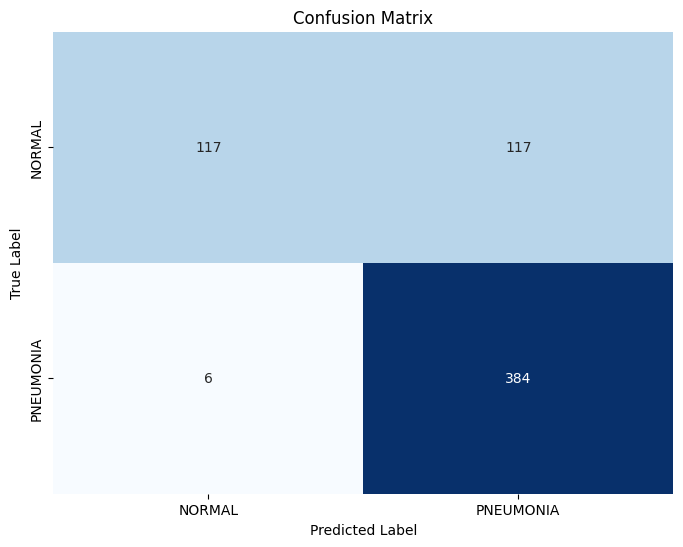

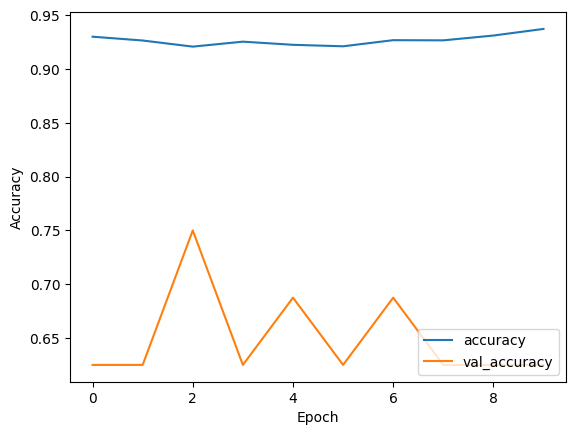

20/20 [==============================] - 1s 16ms/step - loss: 0.5554 - accuracy: 0.8029


[0.5554379820823669, 0.8028846383094788]

In [201]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

show_cm(model)
plot_history(history)
model.evaluate(test_ds)

Further training does not provide any further improvement.

# Summary
So far, we have trained the following models:
- model_1
- model_2
- model_3
- model_4

The best performing model based on the confusion matrix is __model_3__ as it has
minimal __False Negative__ predictions, and overall balanced __True Positives__ and __True Negatives__.

Next notebook will be a testing of all models on the both test sets to get the best generalizable model.